In [1]:
from src.preprocessing.feature_loader import FeatureLoader

feature_loader = FeatureLoader(file_name="feature_extracted")
file_path = feature_loader.data_dir / "feature_extracted.csv"
metadata = feature_loader.load_metadata_file(file_path)
print(metadata.shape)

(1125881, 7)


In [2]:
train_meta, train_emb = feature_loader.transform(split_name="train")
print(train_meta.shape, train_emb.shape)

(788680, 8) (788680, 768)


In [3]:
train_meta = train_meta.reset_index(drop=True)
sampled_train_meta = feature_loader.sample_fraction(metadata=train_meta, fraction=0.1)
sampled_train_emb = train_emb[sampled_train_meta.index]
print(sampled_train_meta.shape, sampled_train_emb.shape)

(78868, 8) (78868, 768)


In [5]:
from umap import UMAP

umap_model = UMAP(
    n_components=2,      # 2 dla wizualizacji, 10–20 dla dalszego klastrowania
    n_neighbors=30,      # większe = gładsza struktura
    min_dist=0.2,
    metric="cosine",  # po L2 odpowiada cosinusowi
    random_state=42,
)

X_umap_2d2 = umap_model.fit_transform(sampled_train_emb)

/Users/mikolajkarapka/Projects/audio-deepfake-detection-uwr/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [7]:
umap_model = UMAP(
    n_components=20,      # 2 dla wizualizacji, 10–20 dla dalszego klastrowania
    n_neighbors=30,      # większe = gładsza struktura
    min_dist=0.1,
    metric="cosine",  # po L2 odpowiada cosinusowi
    random_state=42,
)

X_umap_20d = umap_model.fit_transform(sampled_train_emb)

/Users/mikolajkarapka/Projects/audio-deepfake-detection-uwr/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_umap_clusters(X_umap_2d, clusters, alpha=0.7, cmap='tab20', size=1):
    print(np.sum(clusters == -1))  # Number of noise points
    print(np.unique(clusters, return_counts=True))
    plt.figure(figsize=(10, 8))
    plt.scatter(X_umap_2d[:, 0], X_umap_2d[:, 1], s=size, alpha=alpha, c=clusters, cmap=cmap)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.title("UMAP embeddings")
    plt.colorbar(label='Cluster Label')
    plt.legend()
    plt.show()

23725
(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52]), array([23725,  2485,   714,   711,   716,   677,   572,   586,   647,
        1882,   547,   640,   897,   429,   690,   581,   636,   544,
         689,  4755,   693,   532,  1331,   717,   563,   575,   828,
        1413,   390,  1258,   597,   954,   578,  2066,  1535,   416,
         656,  1049,   745,  1151,   548,  2000,   501,  1431,  2185,
         520,  1140,   549,   905,  1524,   376,  1270,   418,  4331]))


/var/folders/1d/mv_j9c7964b105nch0pj7kgh0000gn/T/ipykernel_77627/430252003.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


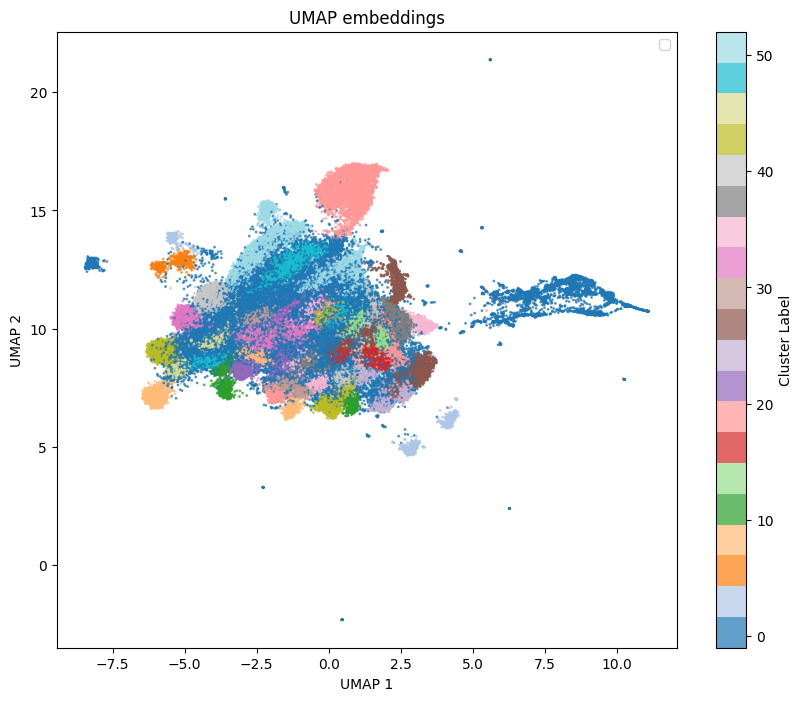

In [9]:
from hdbscan import HDBSCAN

hdbscan_clf = HDBSCAN(
    min_cluster_size=335,
    min_samples=2,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True,
)
hdbscan_clf.fit(X_umap_20d)
clusters = hdbscan_clf.labels_

plot_umap_clusters(X_umap_2d2, clusters, alpha=0.7, cmap='tab20', size=1)

In [ ]:
X_all_umap_20d = umap_model.transform(train_emb)

In [ ]:
from hdbscan import approximate_predict
predicted_labels, strengths = approximate_predict(hdbscan_clf, X_all_umap_20d)

23725
(array([-1]), array([23725]))


/var/folders/1d/mv_j9c7964b105nch0pj7kgh0000gn/T/ipykernel_77627/430252003.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


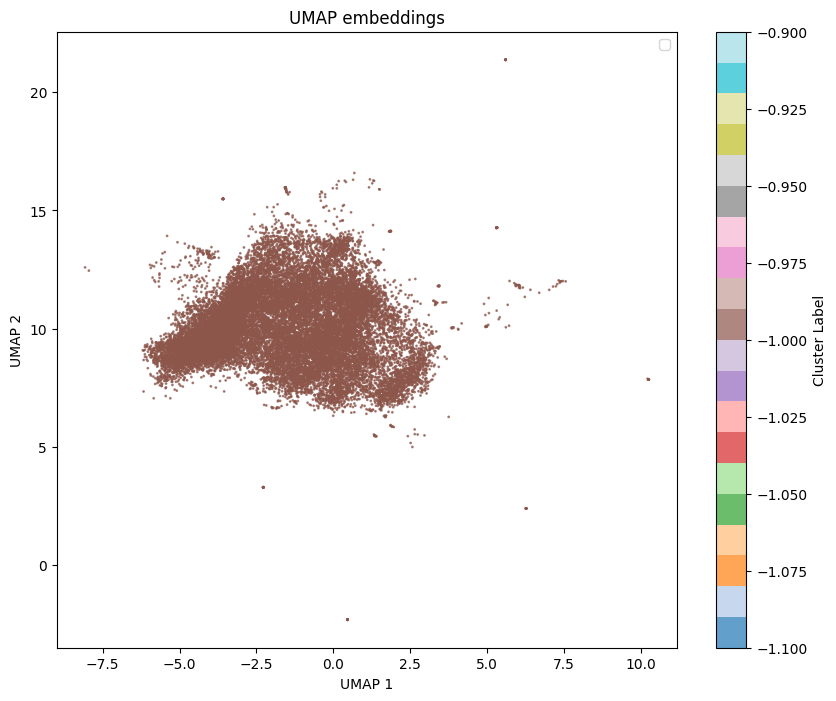

In [10]:
anomaly_indices = np.where(clusters == -1)[0]
plot_umap_clusters(X_umap_2d2[anomaly_indices], clusters[anomaly_indices], alpha=0.7, cmap='tab20', size=1)

In [9]:
uq_config = sampled_train_meta['config'].unique()
mapped_config = {c: i for i, c in enumerate(uq_config)}
config_labels = sampled_train_meta['config'].map(mapped_config).fillna(-1).astype(int).to_numpy()
print(np.unique(config_labels))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


In [ ]:
plt.figure(figsize=(14, 80))
for i, (cfg, _) in enumerate(mapped_config.items()):
    plt.subplot(11, 2, i+1)
    mask = sampled_train_meta['config'] == cfg
    plt.scatter(X_umap_2d2[mask, 0], X_umap_2d2[mask, 1], s=7, alpha=0.7)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.title(f"{cfg}")
plt.tight_layout()

In [4]:
from umap import UMAP
from src.common.constants import Constants as consts

test_umap_model = UMAP(**consts.umap_20d_config)
X_test_umap_20d = test_umap_model.fit_transform(sampled_train_emb)

/Users/mikolajkarapka/Projects/audio-deepfake-detection-uwr/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
